# Time Frequency analysis in ECoG

This week's lab will explore the frequency representation of ECoG. We'll calculate the full time-frequency representation of an ECoG signal, and then focus on a particular frequency band of interest.

We'll now be going back into the world of ECoG, to see what differences we find. We'll use the same "consonant/dissonant" dataset seen in previous weeks. Perhaps by investigating the time-frequency representation of the signal we will uncover things that we couldn't see before...

In [2]:
import mne
import numpy as np
import datascience as ds
import neurods as nds
import matplotlib.pyplot as plt
%matplotlib notebook

* Load in the raw data from the consonant/dissonant task
* Also load the image of the brain and layout of ECoG channels
* Finally, load in the event timing information for this task.

In [3]:
path_ecog = nds.io.data_list['ecog'] + 'chords_task/'
data_path = path_ecog + 'ecog_resamp-raw.fif'
event_path = path_ecog + 'meta_time.csv'

### STUDENT ANSWER
raw = mne.io.Raw(data_path, preload=True)
events = ds.Table.read_table(event_path, index_col=0)
im = plt.imread(path_ecog + 'brain.png')
lt = mne.channels.read_layout('brain', path_ecog)

Opening raw data file /home/shared/cogneuro-connector/data/ecog/chords_task/ecog_resamp-raw.fif...
Isotrak not found
    Range : 0 ... 219521 =      0.000 ...   439.042 secs
Ready.
Reading 0 ... 219521  =      0.000 ...   439.042 secs...


* Convert the events information into an MNE events object. Make sure to include all event types in the events object.
* Also create an events dictionary that maps event types onto event ID numbers.

In [4]:
### STUDENT ANSWER
ev_ixs = events['start'] * raw.info['sfreq']
ev_ixs = ev_ixs.astype(int)
ev_types = np.where(events['type'] == 'consonant', 1, 2)
ev_mne = np.vstack([ev_ixs, np.zeros_like(ev_ixs), ev_types]).T
ev_dict = dict(consonant=1, dissonant=2)

* Using this events array and our events dictionary, convert the `Raw` data to an `Epochs` object
* Plot the global field power for each event type.

In [5]:
### STUDENT ANSWER
epochs = mne.Epochs(raw, ev_mne, event_id=ev_dict,
                    tmin=-.5, tmax=.5, preload=True)

The events passed to the Epochs constructor are not chronologically ordered.
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 501 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


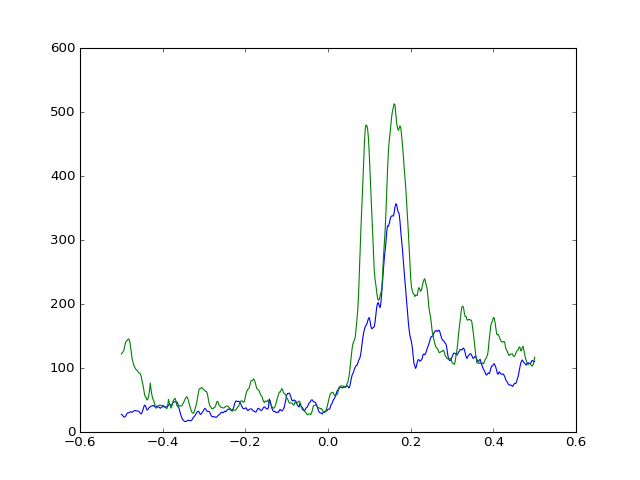

In [6]:
### STUDENT ANSWER
# First, plot the global power of each stim type (for all channels)
f, ax = plt.subplots()
for dtype in ['dissonant', 'consonant']:
    i_data = epochs[dtype]._data.mean(axis=0) ** 2
    i_data = i_data.mean(axis=0)
    ax.plot(epochs.times, i_data)

This is a plot we generated last week. Let's see if something else comes out of a time-frequency analysis.

* Convert the `Epochs` object into a time-frequency representation.
  * Use frequencies from 5 to 140 spaced 2Hz apart
  * Accomplish this with the neurods `tfr_morlet` function.
  * Print the shape of the output for each condition. What does each axis represent?

In [7]:
### STUDENT ANSWER
freqs = np.arange(5, 140, 2)
tfrs = {'consonant': [], 'dissonant': []}
for dtype in ['consonant', 'dissonant']:
    tfrs[dtype] = nds.tfr.tfr_morlet(epochs[dtype]._data, epochs.info['sfreq'],
                                     freqs, average=True, use_fft=True)

100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


* For each condition:
  * Convert the output of `tfr_morlet` into an `AverageTFR` object. This will let you plot it. Use the docstring from `AverageTFR` to figure out how to create an object from data.
  * Plot a topographic map of the TFR for each electrode. Use the `plot_tfr_topo` function in neurods.
  * Plot an image of the brain in the background. For this, use the `add_background_image` function in `mne.viz`.
  * In the call to `plot_topo`, use `mode='zscore', vmin=-5, vmax=5, cmap=plt.cm.coolwarm`

Applying baseline correction (mode: zscore)


<IPython.core.display.Javascript object>


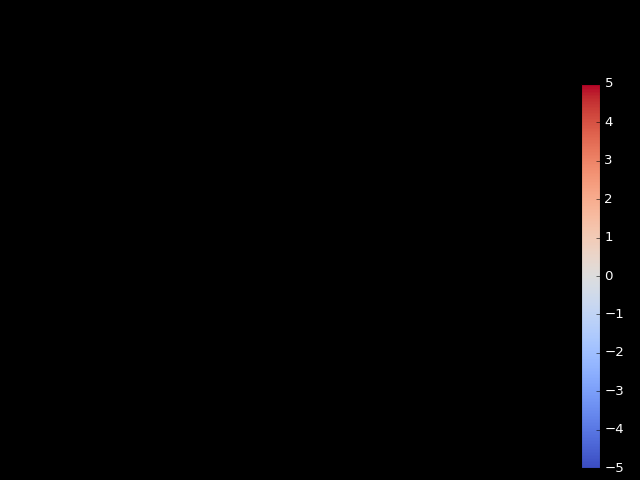

Applying baseline correction (mode: zscore)


<IPython.core.display.Javascript object>


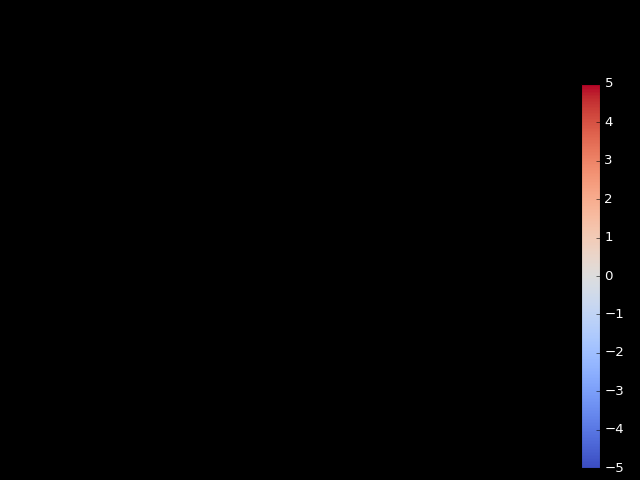

In [8]:
### STUDENT ANSWER
for condition in ['consonant', 'dissonant']:
    avtfr = mne.time_frequency.AverageTFR(epochs.info, tfrs[condition],
                                          epochs.times, freqs,
                                          tfrs[condition].shape[0])
    fig = nds.viz.plot_tfr_topo(avtfr, im, lt)

* Finally, plot the difference (dissonant - consonant) for each TFR. Convert this into an MNE `AverageTFR` object.
* Plot the result on the brain as well.

Applying baseline correction (mode: zscore)


<IPython.core.display.Javascript object>


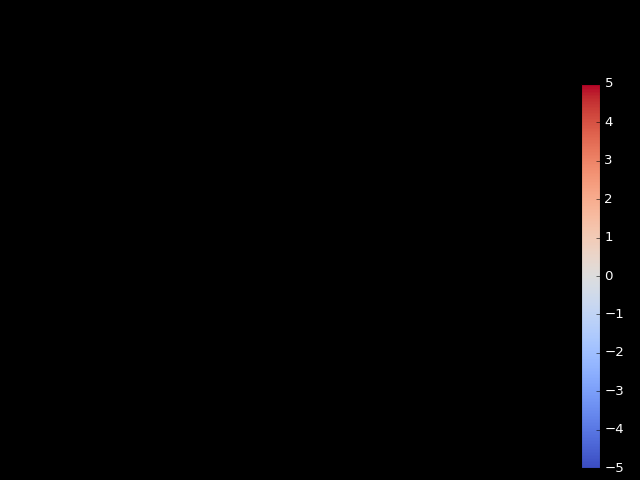

In [9]:
### STUDENT ANSWER
diff = tfrs['dissonant'] - tfrs['consonant']

avtfr = mne.time_frequency.AverageTFR(epochs.info, diff,
                                      epochs.times, freqs,
                                      tfrs['consonant'].shape[0])
_ = nds.viz.plot_tfr_topo(avtfr, im, lt)

* Do you see any differences between the two groups?
* How would you test for a difference between the two?

# Inspecting high-frequency activity
It seems like there are two "blobs" of high-frequency activity in the bove plots. Moreover, these blobs are more localized to specific electrodes than the ERPs of raw activity we saw before. Let's take a look at this activity.

* Extract the first Epoch from the consonant data. Insert it into a new variable.
* Using a bank of morlet wavelets, filter the epoch with 5 equally-spaced frequencies from 70-140Hz.
* Take the "real" component of the result (using `np.real`), and average across frequencies.

In [10]:
### STUDENT ANSWER
freqs = np.linspace(70, 140, 5)
one_epoch = epochs._data[30]
tfr = mne.time_frequency.cwt_morlet(one_epoch, epochs.info['sfreq'], freqs)
tfr = np.real(tfr).mean(1)

* Plot the result in a single plot

<IPython.core.display.Javascript object>


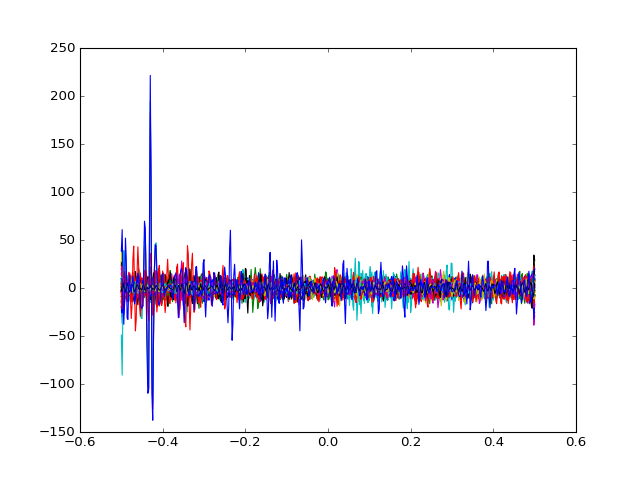

In [11]:
### STUDENT ANSWER
f, ax = plt.subplots()
_ = ax.plot(epochs.times, tfr.T)

* What do you notice about the edges of the plot?
* Try the same process with a few other epochs, see if the edges look consistent.

The peaks that you see at the corners are called "edge artifacts". In order to get around them, we need to remove timepoints near the edges of our data (e.g., at the beginning and end). As such, it is generally better to extract the frequency amplitudes from the **`Raw`** data, and then convert it to epochs.

* Using the `extract_amplitude` function in `neurods`, extract 5 linearly-spaced amplitudes from 70-150 Hz (define them manually or try using `np.linspace`). This function does the same thing that you did above, but it is more efficient with memory use.
* Turn this `Raw` object into an `Epochs` object using the same event times that we used above.

In [12]:
### STUDENT ANSWER
raw_amp = nds.tfr.extract_amplitude(raw, freqs)
ep_amp = mne.Epochs(raw_amp, ev_mne, event_id=ev_dict,
                    tmin=-.5, tmax=.5, preload=True)

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


The events passed to the Epochs constructor are not chronologically ordered.
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 501 original time points ...
0 bad epochs dropped


* Create an average response for each event type 
* Plot this average response (with the `.plot` method)
* For make a list of the top 3 active channels that you determine by visual inspection (you can see the channel names by clicking on each trace)

<IPython.core.display.Javascript object>


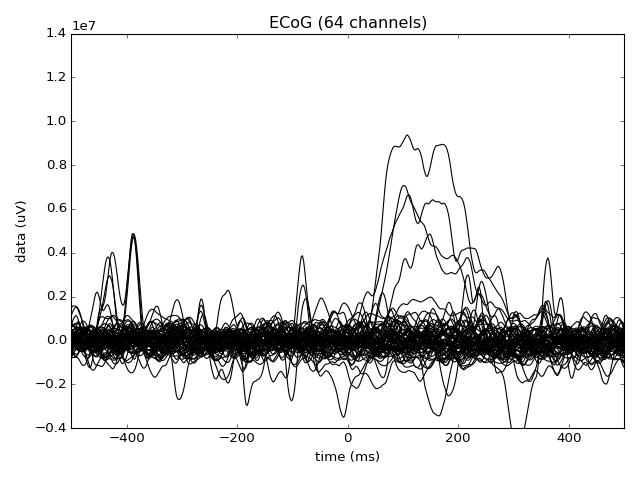

<IPython.core.display.Javascript object>


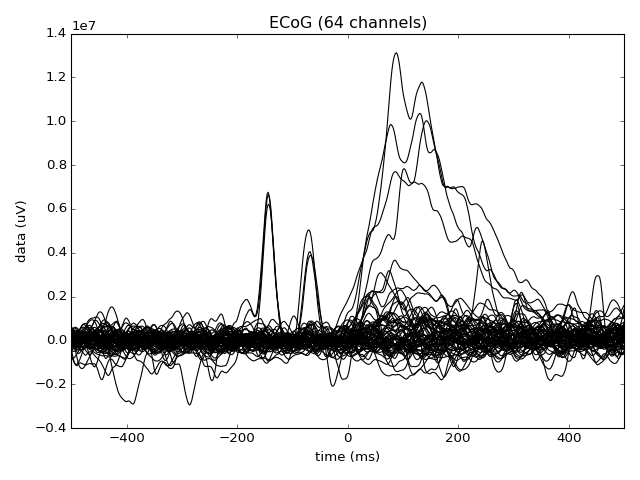

(-4000000.0, 14000000.0)

In [19]:
### STUDENT ANSWER
av_c = ep_amp['consonant'].average()
av_d = ep_amp['dissonant'].average()

fig1 = av_c.plot()
fig2 = av_d.plot()

fig1.axes[0].set_ylim(fig2.axes[0].get_ylim())

In [14]:
### STUDENT ANSWER
active_chs = ['ch_57', 'ch_49', 'ch_50']

* Now, plot each one on the brain using the ECoG layout we loaded above. Remember we can do this with the `plot_topo` function, and don't forget to include an image of the brain as well (which we've also already loaded).

<IPython.core.display.Javascript object>


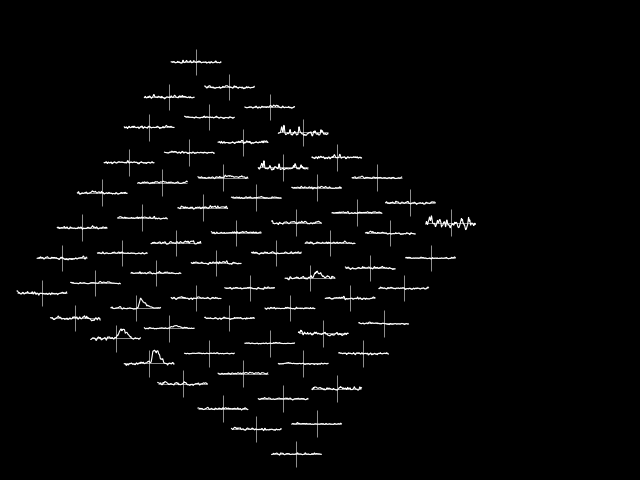

<IPython.core.display.Javascript object>


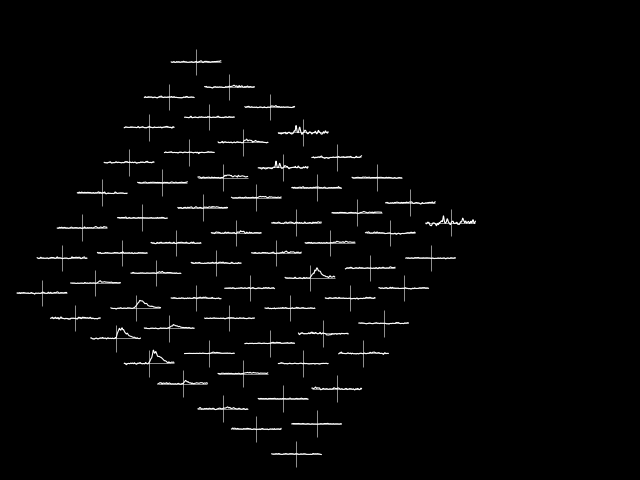

In [15]:
### STUDENT ANSWER
_ = av_c.plot_topo(lt, fig_background=im)
_ = av_d.plot_topo(lt, fig_background=im)

* Finally, plot the difference (dissonant - consonant) between the two on the brain

<IPython.core.display.Javascript object>


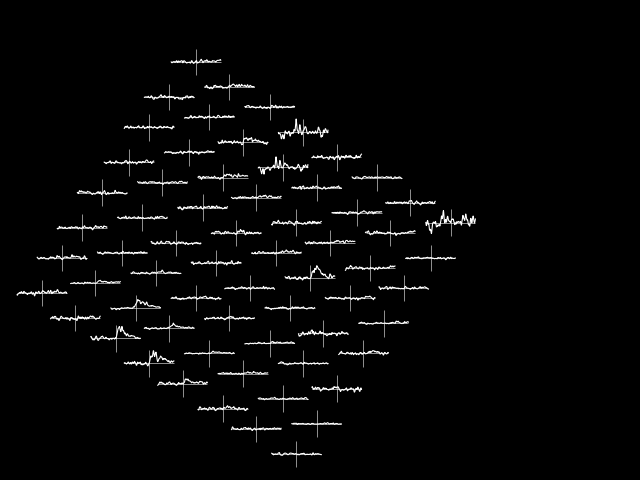

In [16]:
### STUDENT ANSWER
av_diff = av_d - av_c
_ = av_diff.plot_topo(lt, fig_background=im)

* Does it look like there is a difference between the two?
* Is it more or less localized than the signals that we've looked at so far?
* Why or why not?

In [17]:
### STUDENT ANSWER

# Bonus: Confidence intervals
Now that we've calculated the evoked high-frequency amplitude for two conditions, let's test to see if there is a difference between them.

* For the 3 most active electrodes:
* Using the bootstrap method, calculate the confidence interval for the difference between our two conditions
  * Note that our trials are not naturally paired, so you'll have to take a sample of trials in each group first, calculate their mean, and then store that value
* Plot the histogram of bootstrapped differences, as well as 95 and 99% confidence intervals.
* Do you conclude that there is a significant difference between the two conditions for any of these channels?
* Why do you think this is, or is not, the case?

In [18]:
### STUDENT ANSWER